# This is the control room for A2C training with continuous action-space
It will allow you to..
* Play around with an n-step A2C agent (**I**), follow it's live performance and visualize the learned policy (**II**)
* Get an insight into how different agent configurations affect performance and convergence stability (**III** )

### How to
* If you want to see the agent training in live just follow the notebook instructions in the order presented
* If you are in a hurry and are just interested in the results this A2C- implementation achieved, fast forward to (**III**)
* For details on the methods that are used to train the agent, please refer to the 'train_continuous_distinct_NN.py' and 'a2cagent_continuous_distinct_NN.py' scripts, you will find documentation there
* For more theoretical background on the A2C method, please refer to the **FOUNDATIONS** section in the README.md file

In [1]:
%%capture 
#hide loading information

#import python files and modules
import tensorflow as tf
import datetime, os
import a2cagent_continuous_distinct_NN
import train_continuous_distinct_NN as train
;

2022-12-14 10:16:04.735980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 10:16:04.958404: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 10:16:04.963437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 10:16:04.963474: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Information on the distinct_NN agent

- We saw that **state normalisation** helped the distinct agent a great deal, since the observation_space is the same for both 
- **Batch normalisation** had only negative effects on the discrete agent, which is why this agent does not feature the option anymore

- Some articles mentioned **gradient clipping** to be essential to the continuous agent's learning progress, so this is a new feature

- $learning-rate_{critic} >> learning-rate_{actor}$  (lr values can now also be set as argument when starting a sesion)

**DIFFERENCES TO THE *SHARED_NN*-VERSION:**

- critic NN has more nodes than actor NN now (this was suggested in literature)




## I Use the A2C to learn a control task

#### Enable TensorBoard

In [5]:
%load_ext tensorboard

#### Initialize Training Session

In [2]:
%%capture
session = train.Session(converged_reward_limit=195, env_str="ContinuousCartPoleEnv", gradient_clipnorm=0.5, lr_actor=0.0001,lr_critic=0.001, 
activation_function='mish', initializer='xavier', state_normalization=True, specification="JUPYTER_DEMO_RUN", use_existing_policy=False)
# run for 1 batch to initialize
session.train(max_num_batches=1)
# define tensorflow data log
tb_dir = session.model.tb_path + '/'
;

2022-12-14 10:16:13.792282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 10:16:13.792349: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 10:16:13.792370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DJJB008): /proc/driver/nvidia/version does not exist
2022-12-14 10:16:13.792665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Start TensorBoard Session
1. Run the next block twice (until TensorBoard shows up)
2. Use the 'Settings'-button on the top right corner and activate 'Reload data'  (alternatively make yourself familiar with the 'Update' button)
3. **Settings>General>HorizontalAxis>Relative** might make for a better experience

*NOTE (y-axis)*: 

If you use HorizontalAxis> Step rewards are visualized over 'number of episodes', while losses are visualized over 'number of batches'

In [7]:
%tensorboard --logdir {tb_dir}

Reusing TensorBoard on port 6006 (pid 32694), started 0:00:01 ago. (Use '!kill 32694' to kill it.)

### Start training and interupt for visualization
1. By executing the next block, training will be initialized
2. In order to watch progress return to TensorBoard Dashboard

Dashboard will be updated every 30sec or else when you hit the 'Update' button

##### We will now run the training script for short number of episodes, before we interupt the effort in order to visualize the control behaviour. We might be able to derive some clues from this:

In [8]:
%%capture 
# we will just run a few batches
session.train(max_num_batches=20) 


#### Visualisation 1 (after 20 batches):
 Let's visualize the the policy learned above!

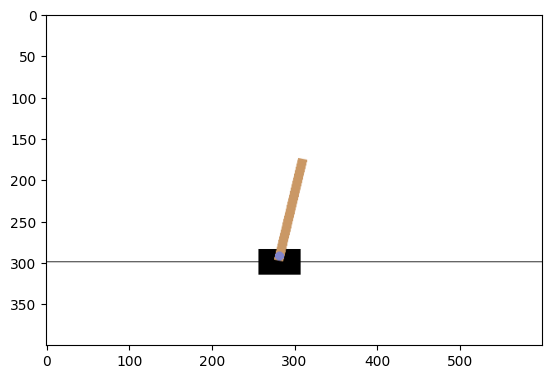

In [9]:
session.test(num_episodes=2)

### Visualization 2: After 70 batches
Continue learning for a bit from where we took off
(Check our TensorBoard first, because once you continue training it won't show prior progress)

In [7]:
%%capture 
# run a few more batches
session.train(max_num_batches=50) 

##### The rewards in TensorBoard might already give you an indication, whether this thing is going to do better than what we avhieved after a few batches in **Visualisation 1**

- Can you see an improvement in the policy?

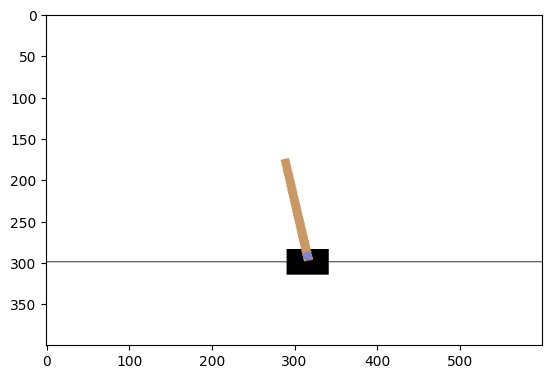

In [10]:
session.test(num_episodes=2)

### You can play around in this Notebook section, by changing the train() configurations above and starting all over, you might find a configuration that leads to success, who knows :)
- Play with learning rates and gradient clipnorm
- Play with activation function and initializer
- You can also switch environment to 'MountainCarContinuous-v0' or use the Bullet version of CartPole 'CartPoleContinuousBulletEnv-v0'

#### Here is a full list of Session() arguments:
    """
    Defines a training session prior to starting training.

    env_str:                ["ContinuousCartPoleEnv" "CartPoleContinuousBulletEnv-v0" "MountainCarContinuous-v0"]
    converged_reward_limit: If mean reward over 100 episodes is >= 'converged_reward_limit' training stops
                            [NOTE: only well defined for CartPole, for every other environment set to a very high number and adjust with 'train(max_num_batches)' only]
    gradient_clipnorm:      None/float introduces gradient clipping into the update of both NN.
                            [NOTE: If set, all gradients are clipped such that their norm is <= gradient_clipnorm]
    lr_actor = 0.00002      You can set your own learning rates
    lr_critic = 0.001       You can set your own learning rates
    activation_function:    ['relu', 'mish']
    initializer:            ['normal', 'xavier']
    state_normalization:    True/False
    specification:          string (You can add a custom add_on to the name of the session)
    use_existing_policy:    True/False
    policy:                 =None / path to dir of form 'A2C281120221423CartPole-v1_mish' relative to AppliedDeep../training_continuous/ as string
                            [NOTE: if policy is not provided, you will be asked to provide the Session-name of the policy you want to reuse 
                            (path to dir of form 'A2C281120221423CartPole-v1_mish' relative to AppliedDeep../training_continuous/ dir as string)]
    """

## III Convergence analysis and comparisson to the shared_NN implementation



In [ ]:
tb_pretrained = os.getcwd()+'/training_continuous/distinct_NN/pretrained/'

%tensorboard --logdir {tb_pretrained}